In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.backend import get_value
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../'
sys.path.insert(0, path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

['../../mavenn']


In [2]:
# Import dataset splitter from sklearn
from sklearn.model_selection import train_test_split

# Load dataset as a dataframe
data_df = mavenn.load_example_dataset('sortseq')

# Extract x and y as np.arrays
x = data_df['x'].values
y = data_df['y'].values
ct = data_df['ct'].values

# Split into training and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [3]:
data_df.head()

,y,ct,x
0,4,23.0,GGCTGTTCACTTTATGCTTCCGGCTTGTATTTTGTGTGC
1,2,12.0,GGTTTTACACATTATGCTTCCGGCTCGTCTCTTGTGTGG
2,1,11.0,GGCTTAACACTTAATGCTTCCGGCTCGTATGTTGTGTGG
3,5,10.0,GGTTTTACACTTTATGCTTCCCGCTCGTAAGGTGTGTCG
4,2,10.0,GGCTTTACACTTTATGCGTCCGGCTCGTATGTTGCGTGG


In [4]:
# Define a model with a pairwise G-P map
# a heteroskedastic Gaussian GE measurement process,
# and specify the training data.
mavenn.set_seed(0)

model = mavenn.Model(x=x,
                     y=y,
                     ct_n=ct,
                     gpmap_type='additive',
                     alphabet='dna',
                     regression_type='MPA')

# Fit model to training data
start_time = time.time()
model.fit(epochs=10,
          learning_rate=0.01,
          early_stopping=True,
          early_stopping_patience=20)
training_time = time.time()-start_time
print(f'training time: {training_time:.1f} seconds')

Epoch 1/10
733/733 [==============================] - 1s 1ms/step - loss: 143.4548 - val_loss: 141.7848
Epoch 2/10
733/733 [==============================] - 1s 1ms/step - loss: 139.3058 - val_loss: 141.7928
Epoch 3/10
733/733 [==============================] - 1s 1ms/step - loss: 138.9803 - val_loss: 140.7527
Epoch 4/10
733/733 [==============================] - 1s 1ms/step - loss: 138.7766 - val_loss: 141.0634
Epoch 5/10
733/733 [==============================] - 1s 1ms/step - loss: 138.5662 - val_loss: 140.8011
Epoch 6/10
733/733 [==============================] - 1s 2ms/step - loss: 138.5517 - val_loss: 141.0807
Epoch 7/10
733/733 [==============================] - 1s 1ms/step - loss: 138.4964 - val_loss: 140.7459
Epoch 8/10
733/733 [==============================] - 1s 1ms/step - loss: 138.4562 - val_loss: 141.3588
Epoch 9/10
733/733 [==============================] - 1s 1ms/step - loss: 138.3875 - val_loss: 140.8738
Epoch 10/10
733/733 [==============================] - 1s 1ms/st

In [5]:
# Save model
model.save('sortseq')

Model saved to these files:
	sortseq.pickle
	sortseq.h5


In [6]:
# Load model
model = mavenn.load('sortseq')

Model loaded from these files:
	sortseq.pickle
	sortseq.h5


In [7]:
model.get_nn().summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 166)]        0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 156)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            157         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           100         phi[0][0]                        
_______________________________________________________________________________________

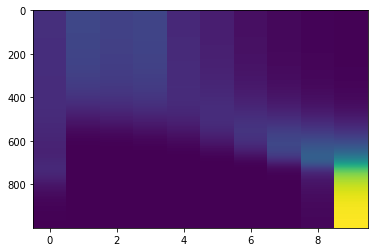

In [16]:
# Predict latent phentoype values (phi) on test data
phi = model.x_to_phi(x)

# Set phi lims and create grid in phi space
phi_lim = [min(phi)-.5, max(phi)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

mat = model.na_p_of_all_y_given_phi(phi_grid)
plt.imshow(mat, aspect='auto', interpolation='nearest')

In [9]:
# Compute mask_dict from trainig data
mask_dict = mavenn.get_mask_dict(x, alphabet='dna')
mask_dict

{}

In [10]:
wt_seq = mavenn.x_to_consensus(x)

theta_add_df = model.get_gpmap_parameters(which='additive')
theta_add_df.head()

,name,value,l,c
0,theta_0:A,-0.055079,0,A
1,theta_0:C,-0.058017,0,C
2,theta_0:G,0.008308,0,G
3,theta_0:T,0.104788,0,T
4,theta_1:A,0.063692,1,A


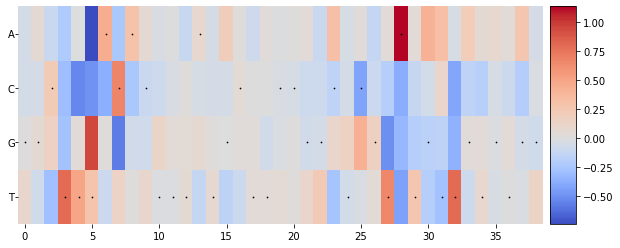

In [11]:
# Illustrate pairwise parameters
fig, ax = plt.subplots(1,1, figsize=[10,4])
ax, cb = mavenn.heatmap(theta_add_df,
                        ax=ax,
                        seq=wt_seq,
                        ccenter=0)